# Solución al problema de Rutas de Vehículos aplicando GNN y CNN

## Librerias

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

path = {"InstanciasMatrices": "Dataset/Instancias/matrices.npy",
        "InstanciasDemandas": "Dataset/Instancias/demandas.npy",
        "InstanciasCapacidades": "Dataset/Instancias/capacidades.npy",
        "aristasVRP": "Dataset/Targets/VRP/aristas.npy",
        "distanciasVRP": "Dataset/Targets/VRP/distancias.npy",
        "aristasCRP": "Dataset/Targets/CVRP/aristas.npy",
        "distanciasCVRP": "Dataset/Targets/CVRP/distancias.npy",
        "cargasCVRP": "Dataset/Targets/CVRP/cargas.npy",
        "FNNmodelVRP": "Models/VRP/FNN.pt",
        "FNNmodelCVRP": "Models/CVRP/FNN.pt"}

In [2]:
device

'cuda'

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#pathColab = "/content/drive/MyDrive/Solucion al problema de Rutas de vehiculos aplicando GNN y CNN"
#for k in path:
#   path[k] = pathColab + "/" + path[k]

## Carga del Dataset

### Instancias

#### Carga

In [5]:
matrices = np.load(path["InstanciasMatrices"])
demandas = np.load(path["InstanciasDemandas"])
capacidades = np.load(path["InstanciasCapacidades"])

#### Elementos a usar

In [6]:
numVehiculos = len(capacidades[0])
l = matrices[0].shape[0]
numInstancias = matrices.shape[0]

vecNumVehiculos = np.array([numVehiculos]*l).reshape((l,1))
vecCapacidades = np.array([np.array([capacidades[i][0]]*numVehiculos*l).reshape((l, numVehiculos))
                           for i in range(numInstancias)])

def matrizAdyacenciaVRP(aristas):
   adjM = np.zeros((l, l))

   for i, j in aristas:
      adjM[i][j], adjM[j][i] = 1, 1
   
   return adjM

def matrizAdyacenciaCVRP(aristas):
   adjM = np.zeros((l, l))

   for i, j, k in aristas:
      adjM[i][j], adjM[j][i] = k, k
   
   return adjM

#### Cantidad

In [7]:
numInstancias

10000

### Target

#### VRP

##### Carga

In [8]:
aristasVRP = np.load(path["aristasVRP"])
distanciasVRP = np.load(path["distanciasVRP"])

##### Cantidad

In [9]:
aristasVRP.shape[0]

10000

##### Cantidad de problemas sin solución

In [10]:
ls = []
for i in range(aristasVRP.shape[0]):
   if(not all((aristasVRP[i] == np.zeros((30, 2))).tolist())):
      ls.append(i)
len(ls)

0

#### Ejemplo

Grafo solución de una instancia

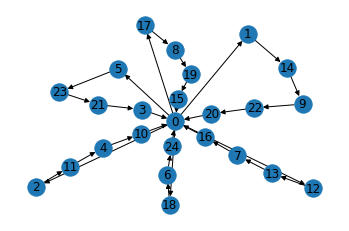

In [11]:
limits = plt.axis("off")
G = nx.DiGraph()
G.add_edges_from(aristasVRP[2])
nx.draw_networkx(G)
plt.show()

#### CVRP

##### Carga

In [12]:
aristasCVRP = np.load(path["aristasCRP"])
distanciasCVRP = np.load(path["distanciasCVRP"])
cargasCVRP = np.load(path["cargasCVRP"])

##### Cantidad

In [13]:
aristasCVRP.shape[0]

10000

##### Cantidad de problemas sin solución

In [14]:
ls = []
for i in range(aristasCVRP.shape[0]):
   if(not all((aristasCVRP[i] == np.zeros((30, 3))).tolist())):
      ls.append(i)
len(ls)

0

#### Ejemplo

Grafo solución de una instancia

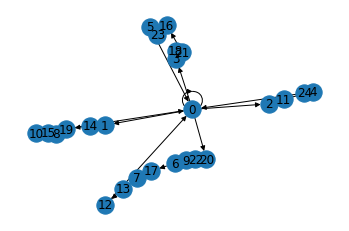

In [15]:
limits = plt.axis("off")
G = nx.DiGraph()
G.add_weighted_edges_from(aristasCVRP[2])
nx.draw_networkx(G)
plt.show()

## Modelos

### Feed-Forward Neural Network

#### Tratamiento de datos

Partición del dataset en train y test

##### VRP

In [16]:
X_VRP = np.array([np.concatenate((matrices[i], vecNumVehiculos), axis=1) 
                  for i in range(numInstancias)])
y_VRP = np.array([matrizAdyacenciaVRP(ari)
                  for ari in aristasVRP])
y_VRP = np.array([M[np.triu_indices_from(M, k=1)]
                  for M in y_VRP])

X_trainVRP, X_testVRP, y_trainVRP, y_testVRP = train_test_split(X_VRP, y_VRP, test_size=0.25, random_state=1)

dimensionX_VRP = X_trainVRP[0].shape[0]*X_trainVRP[0].shape[1]
dimensiony_VRP = y_trainVRP[0].shape[0]

##### CVRP

In [17]:
X_CVRP = np.array([np.concatenate((matrices[i], vecNumVehiculos, demandas[i].reshape((l, 1)), vecCapacidades[i]), axis=1) 
                  for i in range(numInstancias)])
y_CVRP = np.array([matrizAdyacenciaCVRP(ari)
                  for ari in aristasCVRP])
y_CVRP = np.array([M[np.triu_indices_from(M, k=1)]
                  for M in y_CVRP])

X_trainCVRP, X_testCVRP, y_trainCVRP, y_testCVRP = train_test_split(X_CVRP, y_CVRP, test_size=0.25, random_state=1)

dimensionX_CVRP = X_trainCVRP[0].shape[0]*X_trainCVRP[0].shape[1]
dimensiony_CVRP = y_trainCVRP[0].shape[0]

#### Crear Dataset especifico para el modelo

Creación de la clase Dataset para la manipulación de los datos

In [18]:
class Dataset(torch.utils.data.Dataset):
   def __init__(self, X, y):
      self.X = torch.from_numpy(X).float().cuda().view(-1, X[0].shape[0]*X[0].shape[1])
      self.y = torch.from_numpy(y).float().cuda()
   def __len__(self):
      return len(self.X)
   def __getitem__(self, ix):
      return self.X[ix], self.y[ix]

datasetVRP = {
   'train': Dataset(X_trainVRP, y_trainVRP),
   'test': Dataset(X_testVRP, y_testVRP),
}

datasetCVRP = {
   'train': Dataset(X_trainCVRP, y_trainCVRP),
   'test': Dataset(X_testCVRP, y_testCVRP),
}

Se divide el dataset en batches para un mejor entrenamiento usando el modulo utils.data.

In [19]:
dataloaderVRP = {
   'train': torch.utils.data.DataLoader(datasetVRP['train'], batch_size=20, shuffle=True),
   'test': torch.utils.data.DataLoader(datasetVRP['test'], batch_size=250, shuffle=False)
}

dataloaderCVRP = {
   'train': torch.utils.data.DataLoader(datasetCVRP['train'], batch_size=20, shuffle=True),
   'test': torch.utils.data.DataLoader(datasetCVRP['test'], batch_size=250, shuffle=False)
}

#### Definición del modelo

In [20]:
class FNN(torch.nn.Module):
   def __init__(self, D_in, H, D_out):
      super().__init__()
      self.fc1 = torch.nn.Sequential(
                    torch.nn.Linear(D_in, H),
                    torch.nn.ReLU()
                 )
      self.fc2 = torch.nn.Sequential(
                    torch.nn.Linear(H, 2*H),
                    torch.nn.ReLU()
                 )
      self.fc3 = torch.nn.Sequential(
                    torch.nn.Linear(2*H, 2*H),
                    torch.nn.ReLU()
                 )
      self.fc4 = torch.nn.Sequential(
                    torch.nn.Linear(2*H, H),
                    torch.nn.ReLU()
                 )
      self.fc5 = torch.nn.Sequential(
                    torch.nn.Linear(H, D_out),
                    torch.nn.ReLU()
                 )
   
   def forward(self, x):
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      x = self.fc4(x)
      x = self.fc5(x)
      return x

#### Función de entrenamiento

In [21]:
def fit(model, dataloader, epochs=5):
   model.to(device)
   optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
   criterion = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)
   FNNTrainLossMean, FNNValLossMean, FNNTrainAccMean, FNNValAccMean = [0.0], [0.0], [0.0], [0.0]
   for epoch in range(1, epochs+1):
      model.train()
      FNNTrainLoss, FNNTrainAcc = [], []
      batches = dataloader['train']
      for batch in batches:
         X, y = batch
         X, y = X.to(device), y.to(device)
         optimizer.zero_grad()
         y_hat = model(X)
         loss = criterion(torch.nn.functional.log_softmax(y_hat, dim=1), 
                          torch.nn.functional.log_softmax(y, dim=1))
         loss.backward()
         optimizer.step()
         FNNTrainLoss.append(loss.item())
         acc = (y == y_hat).all(axis=1).sum() / len(y)
         FNNTrainAcc.append(acc.to("cpu"))
      batches = dataloader['test']
      FNNValLoss, FNNValAcc = [], []
      model.eval()
      with torch.no_grad():
         for batch in batches:
            X, y = batch
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(torch.nn.functional.log_softmax(y_hat, dim=1),
                             torch.nn.functional.log_softmax(y, dim=1))
            FNNValLoss.append(loss.item())
            acc = (y == y_hat).all(axis=1).sum() / len(y)
            FNNValAcc.append(acc.to("cpu"))
      FNNTrainLossMean.append(np.mean(FNNTrainLoss))
      FNNValLossMean.append(np.mean(FNNValLoss))
      FNNTrainAccMean.append(np.mean(FNNTrainAcc))
      FNNValAccMean.append(np.mean(FNNValAcc))
      print(f"Epoch {epoch}/{epochs} loss {np.mean(FNNTrainLoss):.5f} val_loss {np.mean(FNNValLoss):.5f} acc {np.mean(FNNTrainAcc):.5f} val_acc {np.mean(FNNValAcc):.5f}")
   return FNNTrainLossMean, FNNValLossMean, FNNTrainAccMean, FNNValAccMean

#### VRP

##### Instanciación del modelo

In [22]:
FNN_VRPmodel = FNN(dimensionX_VRP, 700, dimensiony_VRP)
FNN_VRPmodel

FNN(
  (fc1): Sequential(
    (0): Linear(in_features=650, out_features=700, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=700, out_features=1400, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=1400, out_features=1400, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=1400, out_features=700, bias=True)
    (1): ReLU()
  )
  (fc5): Sequential(
    (0): Linear(in_features=700, out_features=300, bias=True)
    (1): ReLU()
  )
)

##### Entrenamiento

In [23]:
epochs = 50

FNNTrainLossVRP, FNNValLossVRP, FNNTrainAccVRP, FNNValAccVRP = fit(FNN_VRPmodel,
                                                                   dataloaderVRP,
                                                                   epochs=epochs)

Epoch 1/50 loss 2.61591 val_loss 0.06090 acc 0.00000 val_acc 0.00000
Epoch 2/50 loss 0.06080 val_loss 0.06076 acc 0.00000 val_acc 0.00000
Epoch 3/50 loss 0.06071 val_loss 0.06064 acc 0.00000 val_acc 0.00000
Epoch 4/50 loss 0.06064 val_loss 0.06071 acc 0.00000 val_acc 0.00000
Epoch 5/50 loss 0.06060 val_loss 0.06062 acc 0.00000 val_acc 0.00000
Epoch 6/50 loss 0.06055 val_loss 0.06055 acc 0.00000 val_acc 0.00000
Epoch 7/50 loss 0.06051 val_loss 0.06048 acc 0.00000 val_acc 0.00000
Epoch 8/50 loss 0.06044 val_loss 0.06049 acc 0.00000 val_acc 0.00000
Epoch 9/50 loss 0.06034 val_loss 0.06064 acc 0.00000 val_acc 0.00000
Epoch 10/50 loss 0.06025 val_loss 0.06021 acc 0.00000 val_acc 0.00000
Epoch 11/50 loss 0.06011 val_loss 0.06008 acc 0.00000 val_acc 0.00000
Epoch 12/50 loss 0.05993 val_loss 0.06004 acc 0.00000 val_acc 0.00000
Epoch 13/50 loss 0.05979 val_loss 0.05979 acc 0.00000 val_acc 0.00000
Epoch 14/50 loss 0.05965 val_loss 0.05961 acc 0.00000 val_acc 0.00000
Epoch 15/50 loss 0.05948 val_

##### Gráficas de métricas

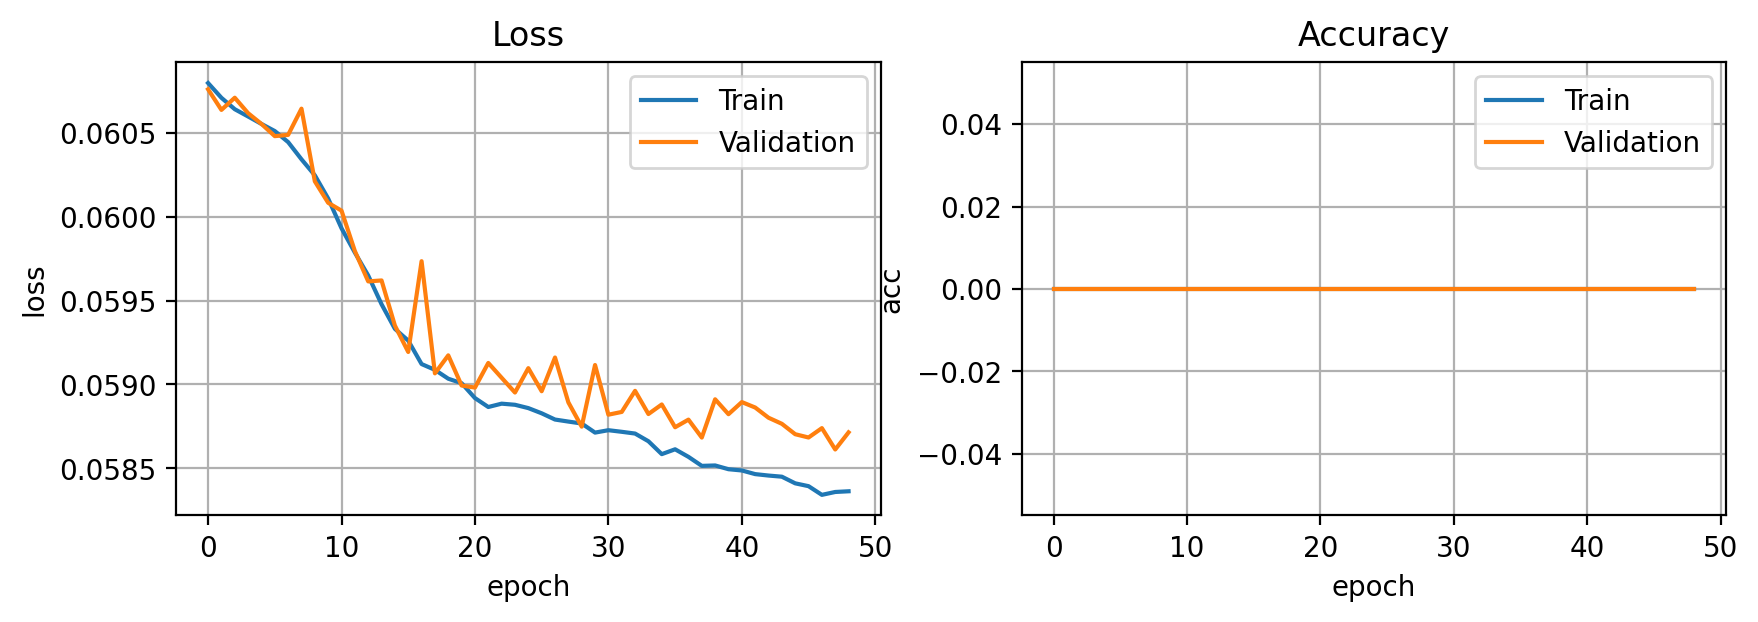

In [24]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(FNNTrainLossVRP[2:], label="Train")
ax.plot(FNNValLossVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(FNNTrainAccVRP[2:], label="Train")
ax.plot(FNNValAccVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Accuracy')
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

##### Guardando el modelo

In [30]:
torch.save(FNN_VRPmodel.state_dict(), path["FNNmodelVRP"])

#### CVRP

##### Instanciación del modelo

In [26]:
FNN_CVRPmodel = FNN(dimensionX_CVRP, 1000, dimensiony_CVRP)
FNN_CVRPmodel

FNN(
  (fc1): Sequential(
    (0): Linear(in_features=825, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=2000, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=2000, out_features=2000, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=2000, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc5): Sequential(
    (0): Linear(in_features=1000, out_features=300, bias=True)
    (1): ReLU()
  )
)

##### Entrenamiento

In [27]:
epochs = 50

FNNTrainLossCVRP, FNNValLossCVRP, FNNTrainAccCVRP, FNNValAccCVRP = fit(FNN_CVRPmodel,
                                                                       dataloaderCVRP,
                                                                       epochs=epochs)

Epoch 1/50 loss 6.59231 val_loss 3.38034 acc 0.00000 val_acc 0.00000
Epoch 2/50 loss 3.34186 val_loss 3.32591 acc 0.00000 val_acc 0.00000
Epoch 3/50 loss 3.33461 val_loss 3.32600 acc 0.00000 val_acc 0.00000
Epoch 4/50 loss 3.33389 val_loss 3.33006 acc 0.00000 val_acc 0.00000
Epoch 5/50 loss 3.33383 val_loss 3.32454 acc 0.00000 val_acc 0.00000
Epoch 6/50 loss 3.33381 val_loss 3.32394 acc 0.00000 val_acc 0.00000
Epoch 7/50 loss 3.33366 val_loss 3.32347 acc 0.00000 val_acc 0.00000
Epoch 8/50 loss 3.33395 val_loss 3.32507 acc 0.00000 val_acc 0.00000
Epoch 9/50 loss 3.33335 val_loss 3.32384 acc 0.00000 val_acc 0.00000
Epoch 10/50 loss 3.33365 val_loss 3.32367 acc 0.00000 val_acc 0.00000
Epoch 11/50 loss 3.33353 val_loss 3.32381 acc 0.00000 val_acc 0.00000
Epoch 12/50 loss 3.33445 val_loss 3.32417 acc 0.00000 val_acc 0.00000
Epoch 13/50 loss 3.33305 val_loss 3.32444 acc 0.00000 val_acc 0.00000
Epoch 14/50 loss 3.33295 val_loss 3.32444 acc 0.00000 val_acc 0.00000
Epoch 15/50 loss 3.33285 val_

##### Gráficas de métricas

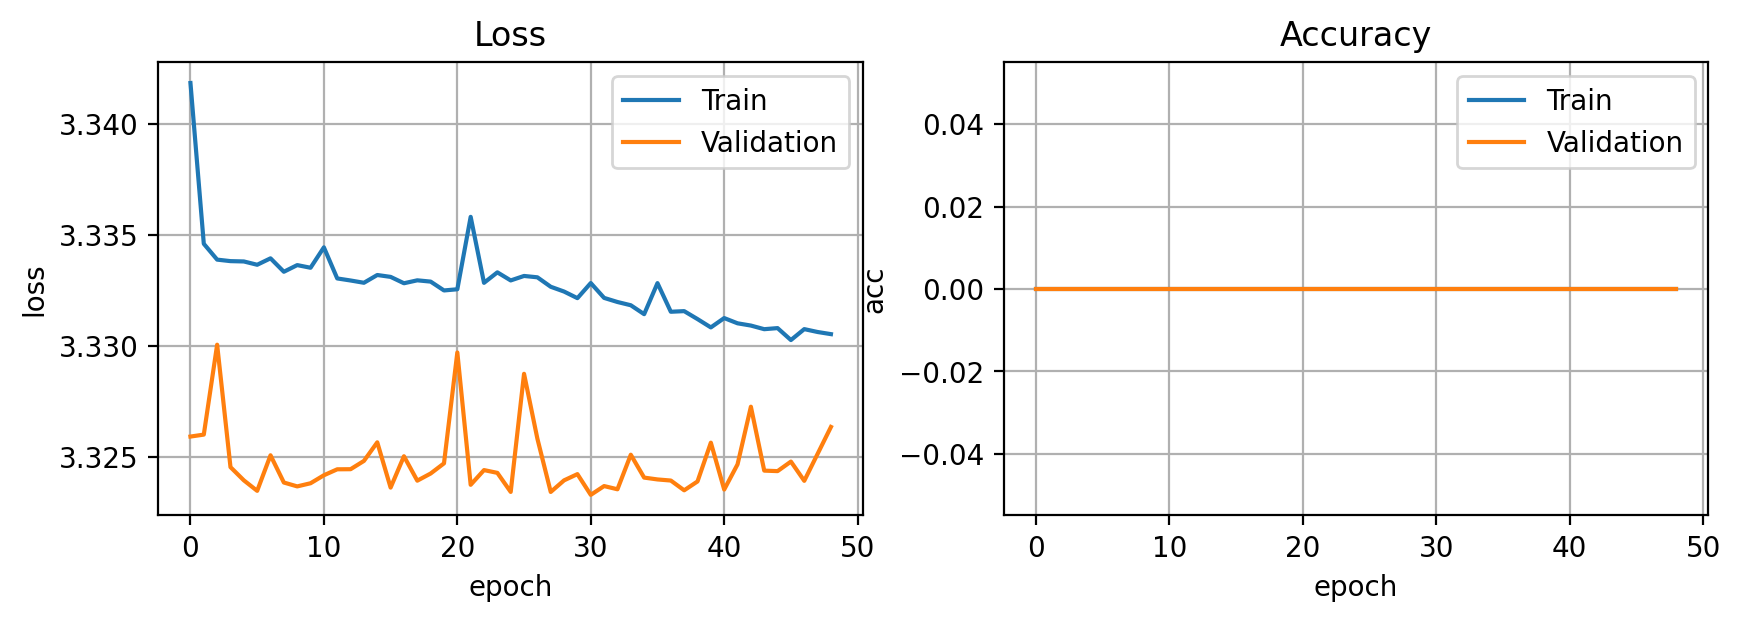

In [28]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(FNNTrainLossCVRP[2:], label="Train")
ax.plot(FNNValLossCVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(FNNTrainAccCVRP[2:], label="Train")
ax.plot(FNNValAccCVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Accuracy')
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

##### Guardando el modelo

In [31]:
torch.save(FNN_CVRPmodel.state_dict(), path["FNNmodelCVRP"])